In [83]:
#images sampled from Google Earth
#https://earth.google.com/web/
#permissions explained here:
#https://www.google.com/intl/en-GB_ALL/permissions/geoguidelines/#:~:text=Generally%20speaking%2C%20as%20long%20as,Google%20Earth%20and%20Street%20View.

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
import PIL
import matplotlib.patches as patches

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
Adam = keras.optimizers.Adam

In [84]:
train_data = pathlib.Path('data/')

batch_size = 4 #mini batches. For this small data set this works pretty well
img_height = 200
img_width = 200

In [85]:
#80-20 train-validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    validation_split=.2,
    subset="training",
    seed=27,
    image_size=(img_height, img_width),
    batch_size = batch_size)

class_names = train_ds.class_names

Found 60 files belonging to 2 classes.
Using 48 files for training.


In [86]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    validation_split=.2,
    subset="validation",
    seed=27,
    image_size=(img_height, img_width),
    batch_size = batch_size)

Found 60 files belonging to 2 classes.
Using 12 files for validation.


In [87]:
#improving performance by caching images according to TF documentation
#making sure to shuffle the images that are cached
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
num_classes = len(class_names)
#layers include rescaling, 3 convolution layers (2 had bad results), and two dense layers (more seems to overfit)
model = Sequential([
  #normalized. model works better with small values (<1). Handles input shape for subsequent layers.
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #16 dimensional ouput, 3x3 kernel size/convolution window, window padding with 0s, relu activation. 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #each convolution layer must be pooled
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #we want two outputs for training and validation
  layers.Dense(num_classes)
])

In [89]:
#adam optimizer, making learning rate parameter. Using built in accuracy metric. 
#SparceCategorialCrossentropy is used when having multiple label classes. Logits handle precision error
model.compile(optimizer=Adam(learning_rate=.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 50, 50, 64)       

In [91]:
#tested this to be a good amount of epochs without overfitting
#overfitting seems to happen pretty quickly
#results depend a bit on the shuffle of images it seems like
#sample size is overall pretty small
#two images in particular are hard to classify and susceptible to bias
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 2s 119ms/step - loss: 0.7325 - accuracy: 0.5208 - val_loss: 0.6090 - val_accuracy: 0.5000
Epoch 2/10
12/12 [==============================] - 1s 110ms/step - loss: 0.6404 - accuracy: 0.5625 - val_loss: 0.6728 - val_accuracy: 0.5000
Epoch 3/10
12/12 [==============================] - 1s 111ms/step - loss: 0.4936 - accuracy: 0.8750 - val_loss: 0.1854 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 1s 117ms/step - loss: 0.2283 - accuracy: 0.9375 - val_loss: 1.1960 - val_accuracy: 0.7500
Epoch 5/10
12/12 [==============================] - 1s 114ms/step - loss: 0.2273 - accuracy: 0.9167 - val_loss: 0.0291 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 1s 118ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 1s 119ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 4.0947e-05 - val_accuracy: 1.0000
Ep

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Accuracy')

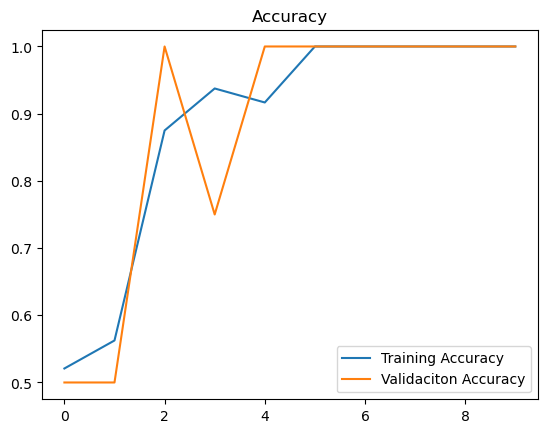

In [93]:
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validaciton Accuracy')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

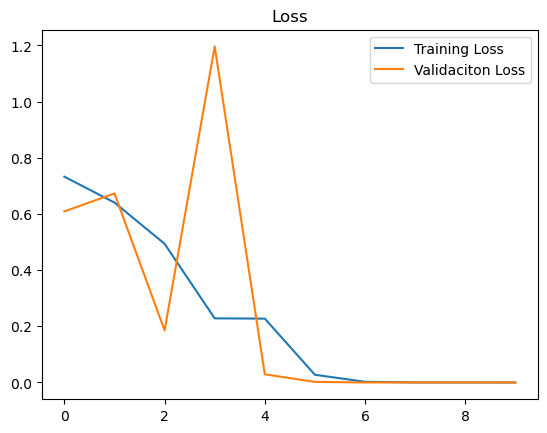

In [94]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validaciton Loss')
plt.legend()
plt.title('Loss')

1/1 [==============================] - 0s 65ms/step


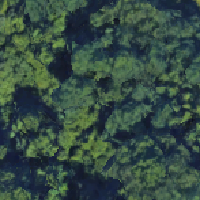

Category: trees, Confidence: 100.00
1/1 [==============================] - 0s 23ms/step


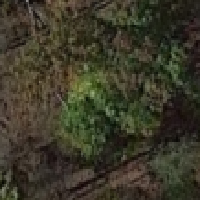

Category: trees, Confidence: 100.00
1/1 [==============================] - 0s 22ms/step


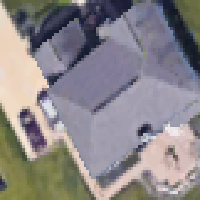

Category: houses, Confidence: 100.00
1/1 [==============================] - 0s 23ms/step


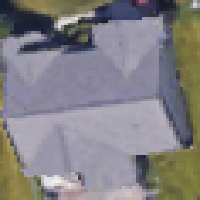

Category: houses, Confidence: 100.00
1/1 [==============================] - 0s 38ms/step


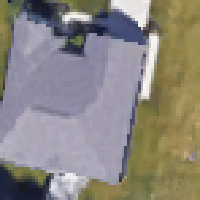

Category: houses, Confidence: 100.00
1/1 [==============================] - 0s 25ms/step


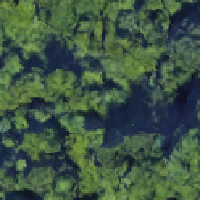

Category: trees, Confidence: 100.00
1/1 [==============================] - 0s 26ms/step


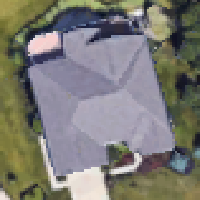

Category: houses, Confidence: 100.00
1/1 [==============================] - 0s 30ms/step


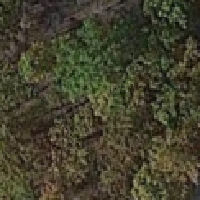

Category: trees, Confidence: 100.00
1/1 [==============================] - 0s 34ms/step


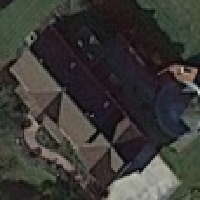

Category: trees, Confidence: 100.00
1/1 [==============================] - 0s 29ms/step


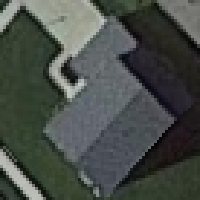

Category: trees, Confidence: 51.42


In [95]:
#testing data
test_data = pathlib.Path('test/')
for e in test_data.iterdir():
    test_img = tf.keras.utils.load_img(
        str(e), target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    display(test_img)
    print(
        "Category: {}, Confidence: {:.2f}"
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )



From the test set above we have about 80% accuracy for the current training. The small sample size leads to overfitting quickly
in some cases. 

In [96]:
full_height = 300
full_width = 500
step_size = 20
full_image_path = pathlib.Path('fullimages/')
full_images = list(full_image_path.glob('*'))

full_img_1 = tf.keras.utils.load_img(
        str(full_images[0]), target_size=(full_height, full_width)
    )
full_img_2 = tf.keras.utils.load_img(
        str(full_images[1]), target_size=(full_height, full_width)
    )
full_img_3 = tf.keras.utils.load_img(
        str(full_images[2]), target_size=(full_height, full_width)
    )


In [97]:
def populate_img_list(img, array):
    width, height = img.size
    for i in range(step_size):
        for j in range(step_size):
            left = i*full_width/step_size
            top = j*full_height/step_size
            right = left + full_width/step_size
            bottom = top + full_height/step_size
            array.append(img.crop((left, top, right, bottom))) 

def populate_category_array(cat, img):
    for e in img:
        img_part = tf.image.resize(e, (200,200))
        img_array = tf.keras.utils.img_to_array(img_part)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        cat.append([class_names[np.argmax(score)], 100 * np.max(score)])

def plot_and_color(ca, img):
    fig, ax = plt.subplots()
    for i in range(ca.shape[0]):
        for j in range(ca.shape[1]):
            ec = 'r' if ca[i][j][0] == 'houses' else 'g'
            rect = patches.Rectangle((i*full_width/step_size, 
                                      j*full_height/step_size), 
                                     full_width/step_size, 
                                     full_height/step_size, 
                                     linewidth=1, 
                                     edgecolor='none', 
                                     facecolor=ec, alpha = .4)
            ax.add_patch(rect)
            prev = ec

    ax.imshow(img)
    plt.title('Houses: Red Shading, Trees: Green Shading')
    plt.show()

In [98]:
%%capture
img_list_1 = []
populate_img_list(full_img_1, img_list_1)
cat_list_1 = []
populate_category_array(cat_list_1, img_list_1)
ca1 = np.array(cat_list_1).reshape([step_size,step_size,2])

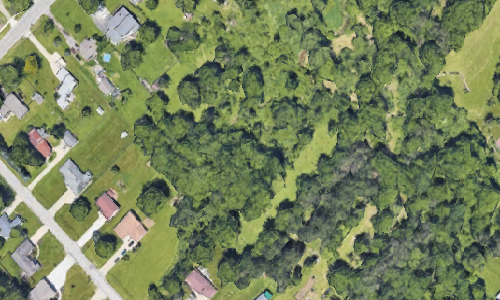

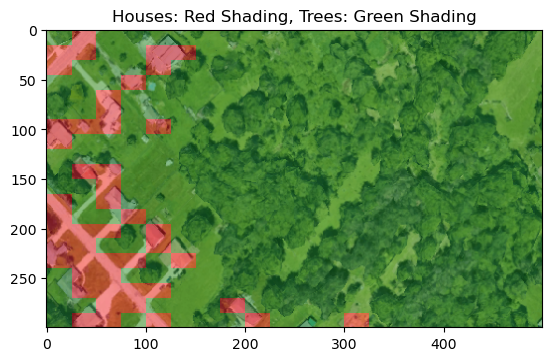

In [99]:
display(full_img_1)
plot_and_color(ca1, full_img_1)

For the full image we will judge accuracy by missed labelings out of 400. 
This is about 390/400 accuracy. 

In [100]:
%%capture
img_list_2 = []
populate_img_list(full_img_2, img_list_2)
cat_list_2 = []
populate_category_array(cat_list_2, img_list_2)
ca2 = np.array(cat_list_2).reshape([step_size,step_size,2])

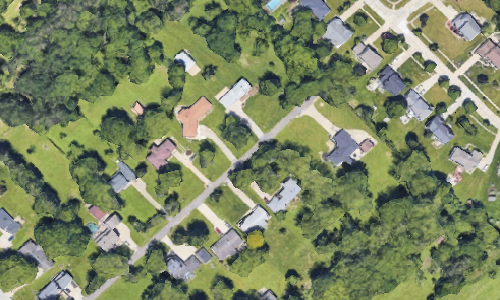

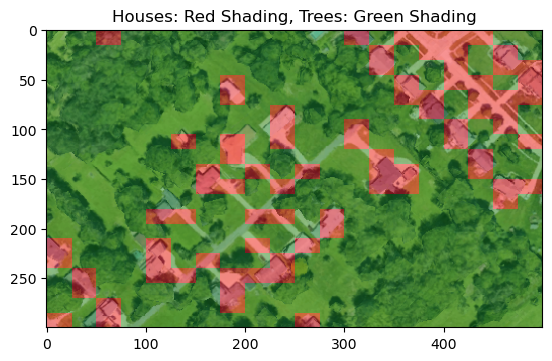

In [101]:
display(full_img_2)
plot_and_color(ca2, full_img_2)

This image is roughly 370/400 accurate

In [102]:
%%capture
img_list_3 = []
populate_img_list(full_img_3, img_list_3)
cat_list_3 = []
populate_category_array(cat_list_3, img_list_3)
ca2 = np.array(cat_list_3).reshape([step_size,step_size,2])

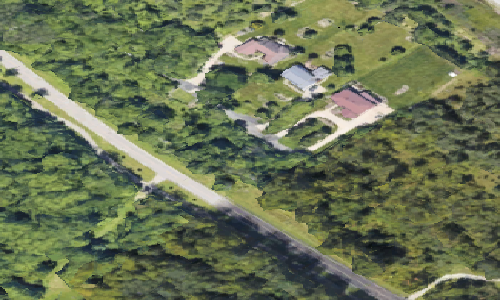

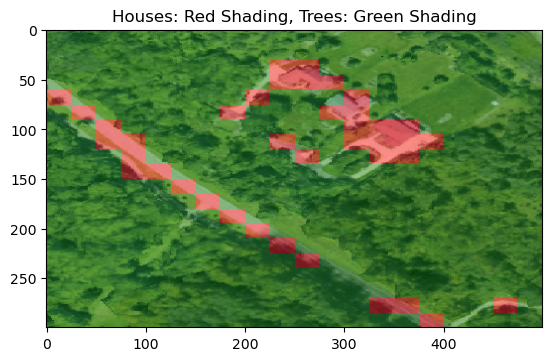

In [103]:
display(full_img_3)
plot_and_color(ca2, full_img_3)

This image also sees about 370/400 accuracy